### Remove saved ones concepts trying new course

In [1]:
%rm -r cav
%rm -r Raindrop/code/cav

rm: cannot remove 'cav': No such file or directory
rm: cannot remove 'Raindrop/code/cav': No such file or directory


In [1]:
import numpy as np
import os
import pandas as pd
import ast
from matplotlib import pyplot as plt

from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str
from scipy.stats import ttest_ind
import torch
import random
import seaborn as sns

/opt/conda/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd Raindrop/code
from models_rd import *
from utils_rd import *

/beerslaw/ML4ED/Raindrop/code


In [75]:
Target = 0
test_target = 0
num_rands = 100
d_inp = 6
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
base_path = '/beerslaw/raindrop_data/prep_data'
raindrop_data_path = '/beerslaw/raindrop_data'
easy_fail_path = '/beerslaw/raindrop_data/easy-fail/'
MOOC = 'dsp-001'
percentile = 40
Pdict_list = np.load(os.path.join(base_path, f"{MOOC}_{percentile}_data_hard_fail.npy"), allow_pickle=True)
arr_outcomes = np.load(os.path.join(base_path, f"{MOOC}_{percentile}_y_hard_fail.npy"), allow_pickle=True)

In [4]:
marras_feats = pd.read_csv(f'/beerslaw/raindrop_data/easy-fail/eq_week-marras_et_al-{MOOC.replace("-", "_")}/feature_labels.csv')
number_id_mapping = pd.read_csv(f'/beerslaw/raindrop_data/easy-fail/user_id_mapping-{MOOC.replace("-", "_")}.csv')

hard_fail_idx = number_id_mapping.merge(marras_feats, on='Unnamed: 0', how='inner')['Unnamed: 0']
number_id_mapping = number_id_mapping.merge(marras_feats, on='Unnamed: 0', how='inner')[['user_id', 'label-pass-fail']]


In [5]:
marras_features = np.load(f"{easy_fail_path}/eq_week-marras_et_al-{MOOC.replace('-', '_')}/feature_values.npz")['feature_values']
boroujeni_features = np.load(f"{easy_fail_path}/eq_week-boroujeni_et_al-{MOOC.replace('-', '_')}/feature_values.npz")['feature_values']
chen_features = np.load(f"{easy_fail_path}/eq_week-chen_cui-{MOOC.replace('-', '_')}/feature_values.npz")['feature_values']
lalle_features = np.load(f"{easy_fail_path}/eq_week-lalle_conati-{MOOC.replace('-', '_')}/feature_values.npz")['feature_values']
mubarak_features = np.load(f"{easy_fail_path}/eq_week-mubarak_et_al-{MOOC.replace('-', '_')}/feature_values.npz")['feature_values']

mubarak_features = mubarak_features[hard_fail_idx]

marras_features = np.nan_to_num(marras_features, nan=0)
boroujeni_features = np.nan_to_num(boroujeni_features, nan=0)
chen_features = np.nan_to_num(chen_features, nan=0)
lalle_features = np.nan_to_num(lalle_features, nan=0)
mubarak_features = np.nan_to_num(mubarak_features, nan=0)

marras_names = open(f"{easy_fail_path}/eq_week-marras_et_al-{MOOC.replace('-', '_')}/settings.txt", 'r').read()
marras_names = ast.literal_eval(marras_names)['feature_names']
boroujeni_names = open(f"{easy_fail_path}/eq_week-boroujeni_et_al-{MOOC.replace('-', '_')}/settings.txt", 'r').read()
boroujeni_names = ast.literal_eval(boroujeni_names)['feature_names']
chen_names = open(f"{easy_fail_path}/eq_week-chen_cui-{MOOC.replace('-', '_')}/settings.txt", 'r').read()
chen_names = ast.literal_eval(chen_names)['feature_names']
lalle_names = open(f"{easy_fail_path}/eq_week-lalle_conati-{MOOC.replace('-', '_')}/settings.txt", 'r').read()
lalle_names = ast.literal_eval(lalle_names)['feature_names']
mubarak_names = open(f"{easy_fail_path}/eq_week-mubarak_et_al-{MOOC.replace('-', '_')}/settings.txt", 'r').read()
mubarak_names = ast.literal_eval(mubarak_names)['feature_names']

marras_names = [f"{'_'.join(name.split('_')[:-1])} {name.split('_')[-1].split(' ')[1]}" if 'function ' in name else name for name in marras_names]
boroujeni_names = [f"{'_'.join(name.split('_')[:-1])} {name.split('_')[-1].split(' ')[1]}" if 'function ' in name else name for name in boroujeni_names]
chen_names = [f"{'_'.join(name.split('_')[:-1])} {name.split('_')[-1].split(' ')[1]}" if 'function ' in name else name for name in chen_names]
lalle_names = [f"{'_'.join(name.split('_')[:-1])} {name.split('_')[-1].split(' ')[1]}" if 'function ' in name else name for name in lalle_names]
mubarak_names = [f"{'_'.join(name.split('_')[:-1])} {name.split('_')[-1].split(' ')[1]}" if 'function ' in name else name for name in mubarak_names]

features_df = pd.DataFrame()
features_df['user_id'] = number_id_mapping['user_id']
features_df['label-pass-fail'] = number_id_mapping['label-pass-fail']
features_df[marras_names] = [[student[:, i] for i in range(marras_features.shape[2])] for student in marras_features]
features_df[boroujeni_names] = [[student[:, i] for i in range(boroujeni_features.shape[2])] for student in boroujeni_features]
features_df[chen_names] = [[student[:, i] for i in range(chen_features.shape[2])] for student in chen_features]
features_df[lalle_names] = [[student[:, i] for i in range(lalle_features.shape[2])] for student in lalle_features]
features_df[mubarak_names] = [[student[:, i] for i in range(mubarak_features.shape[2])] for student in mubarak_features]

features_df['relative_time_online'] = features_df['time_sessions sum'].apply(lambda x: [i/sum(x) for i in x] if sum(x) != 0 else x)
features_df['relative_video_clicks'] = features_df['total_clicks_video'].apply(lambda x: [i/sum(x) for i in x] if sum(x) != 0 else x)


boroujeni_lq_features = np.load(f"{easy_fail_path}/lq_week-boroujeni_et_al-{MOOC.replace('-', '_')}/feature_values.npz", allow_pickle=True)['feature_values']
boroujeni_lq_features = boroujeni_lq_features[hard_fail_idx]
boroujeni_features = np.nan_to_num(boroujeni_lq_features, nan=0)

boroujeni_lq_names = open(f"{easy_fail_path}/lq_week-boroujeni_et_al-{MOOC.replace('-', '_')}/settings.txt", 'r').read()
boroujeni_lq_names = ast.literal_eval(boroujeni_lq_names)['feature_names']
boroujeni_lq_names = [f"{'_'.join(name.split('_')[:-1])} {name.split('_')[-1].split(' ')[1]}" if 'function ' in name else name for name in boroujeni_lq_names]
boroujeni_lq_features = boroujeni_lq_features[:, -1]
features_df[boroujeni_lq_names[-3:]] = [student[-3:] for student in boroujeni_lq_features]



In [6]:
args_train, args_val, args_test = np.load(os.path.join(raindrop_data_path, 
                                                               'split_args', f"split_{MOOC.replace('-', '_')}.npy"),
                                                 allow_pickle=True)
Ptrain = Pdict_list[args_train]
Pval = Pdict_list[args_val]
Ptest = Pdict_list[args_test]
ytrain = arr_outcomes[args_train, :]
yval = arr_outcomes[args_val, :]
ytest = arr_outcomes[args_test, :]


train_zero_indices = [i for i, item in enumerate(Ptrain) if item['length'] == 0]
#zero_Ptrain = Ptrain[zero_indices]
Ptrain = np.delete(Ptrain, train_zero_indices, axis=0)
ytrain = np.delete(ytrain, train_zero_indices, axis=0)

val_zero_indices = [i for i, item in enumerate(Pval) if item['length'] == 0]
#zero_Ptrain = Ptrain[zero_indices]
Pval = np.delete(Pval, val_zero_indices, axis=0)
yval = np.delete(yval, val_zero_indices, axis=0)

test_zero_indices = [i for i, item in enumerate(Ptest) if item['length'] == 0]
zero_ytest = ytest[test_zero_indices]
Ptest = np.delete(Ptest, test_zero_indices, axis=0)  
ytest = np.delete(ytest, test_zero_indices, axis=0)

In [7]:
T, F = Ptrain[0]['arr'].shape
D = len(Ptrain[0]['extended_static'])

Ptrain_tensor = np.zeros((len(Ptrain), T, F))
Ptrain_static_tensor = np.zeros((len(Ptrain), D))

for i in range(len(Ptrain)):
    Ptrain_tensor[i] = Ptrain[i]['arr']
    Ptrain_static_tensor[i] = Ptrain[i]['extended_static']

mf, stdf = getStats(Ptrain_tensor)
ms, ss = getStats_static(Ptrain_static_tensor, dataset='P12')

Ptrain_tensor, Ptrain_static_tensor, Ptrain_time_tensor, ytrain_tensor = tensorize_normalize(Ptrain, ytrain, mf,
                                                                                             stdf, ms, ss)
Pval_tensor, Pval_static_tensor, Pval_time_tensor, yval_tensor = tensorize_normalize(Pval, yval, mf, stdf, ms, ss)

Ptest_tensor, Ptest_static_tensor, Ptest_time_tensor, ytest_tensor = tensorize_normalize(Ptest, ytest, mf, stdf, ms, ss)


Ptrain_tensor = Ptrain_tensor.permute(1, 0, 2)
Pval_tensor = Pval_tensor.permute(1, 0, 2)
Ptest_tensor = Ptest_tensor.permute(1, 0, 2)

Ptrain_time_tensor = Ptrain_time_tensor.squeeze(2).permute(1, 0)
Pval_time_tensor = Pval_time_tensor.squeeze(2).permute(1, 0)
Ptest_time_tensor = Ptest_time_tensor.squeeze(2).permute(1, 0)

/opt/conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
P_tensor = torch.cat([Ptrain_tensor, Pval_tensor], axis=1)
P_static_tensor = torch.cat([Ptrain_static_tensor, Pval_static_tensor])
P_time_tensor = torch.cat([Ptrain_time_tensor, Pval_time_tensor], axis=1)
y_tensor = torch.cat([ytrain_tensor, yval_tensor])

user_id_list = [item['id'] for item in Ptrain]
user_id_list += [item['id'] for item in Pval]

In [9]:
features_df = features_df.drop(args_test, axis=0)
features_df = features_df.drop(args_train[train_zero_indices])
features_df = features_df.drop(args_val[val_zero_indices])

features_df = features_df.reset_index(drop=True)

In [10]:
num_con_students = P_tensor.shape[1]
num_test_students = Ptest_tensor.shape[1]
assert num_con_students == len(features_df)

# Extracting user_ids corresponding to a rule

### Random concepts

In [11]:
rand_concepts = []

for rand_idx in range(num_rands):
    rand_args = np.random.choice(num_con_students, size=(100,), replace=False)
    
    rand_P_tensor = P_tensor[:, rand_args, :]
    rand_P_static_tensor = P_static_tensor[rand_args]
    rand_P_time_tensor = P_time_tensor[:, rand_args]
    rand_y_tensor = y_tensor[rand_args]
    
    rand_concept = Concept(id=1000+rand_idx, name=f"rand_{rand_idx}", data_iter=dataset_to_dataloader(tuple([{'src': rand_P_tensor.cuda(), 
                                                                        'static': rand_P_static_tensor.cuda(),
                                                                        'times': rand_P_time_tensor.cuda(),
                                                                        'lengths': torch.sum(rand_P_time_tensor > 0, dim=0).cuda()
                                                                              }])))
    rand_concepts.append(rand_concept)
    

In [12]:
torch.rand(1)

tensor([0.4963])

# Defining rule functions

In [13]:
def give_top_bot_percent(input_series, n):
    series = input_series[input_series != 0]
    return series.iloc[np.argsort(series)[-int(len(series)*n):]], series.iloc[np.argsort(series)[:int(len(series)*n)]]

In [14]:
experimental_sets = []

## Effort concept:

In [15]:
def effort(features_df, n):
    # Top: Intersection
    # Bot: Union
    effort_df = features_df[['user_id', 'time_sessions sum', 'total_clicks_video']]
    
    top_time_sessions_sum, bot_time_sessions_sum = give_top_bot_percent(effort_df['time_sessions sum'].apply(sum), n)
    top_total_video_clicks, bot_total_video_clicks = give_top_bot_percent(effort_df['total_clicks_video'].apply(sum), n)
    
    top_intersection = np.array(list(set(top_time_sessions_sum.index).intersection(top_total_video_clicks.index)))
    bot_intersection = np.array(list(set(bot_time_sessions_sum.index).union(bot_total_video_clicks.index)))
    
    lim = np.min([len(top_intersection), len(bot_intersection)])
    
    top_intersection = top_intersection[np.random.choice(len(top_intersection), size=(lim,), replace=False)] if len(top_intersection) > lim else top_intersection
    bot_intersection = bot_intersection[np.random.choice(len(bot_intersection), size=(lim,), replace=False)] if len(bot_intersection) > lim else bot_intersection
    
    return top_intersection, bot_intersection

In [16]:
top_effort_args, bot_effort_args = effort(features_df, 0.05)

top_effort_P_tensor = P_tensor[:, top_effort_args, :]
top_effort_P_static_tensor = P_static_tensor[top_effort_args]
top_effort_P_time_tensor = P_time_tensor[:, top_effort_args]
top_effort_y_tensor = y_tensor[top_effort_args]

top_effort_con = Concept(id=0, name="High Effort", data_iter=dataset_to_dataloader(tuple([{'src': top_effort_P_tensor.cuda(), 
                                                                    'static': top_effort_P_static_tensor.cuda(),
                                                                    'times': top_effort_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(top_effort_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

bot_effort_P_tensor = P_tensor[:, bot_effort_args, :]
bot_effort_P_static_tensor = P_static_tensor[bot_effort_args]
bot_effort_P_time_tensor = P_time_tensor[:, bot_effort_args]
bot_effort_y_tensor = y_tensor[bot_effort_args]

bot_effort_con = Concept(id=1, name="Low Effort", data_iter=dataset_to_dataloader(tuple([{'src': bot_effort_P_tensor.cuda(), 
                                                                    'static': bot_effort_P_static_tensor.cuda(),
                                                                    'times': bot_effort_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(bot_effort_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))


#for rand_concept in rand_concepts:
#    experimental_sets.append([top_effort_con, rand_concept])
#for rand_concept in rand_concepts:
#    experimental_sets.append([bot_effort_con, rand_concept])   
if len(top_effort_args) > 0:
    for rand_concept in rand_concepts:
        experimental_sets.append([top_effort_con, bot_effort_con, rand_concept])
    
print(len(top_effort_args))
print(len(bot_effort_args))

94
94


### 

## Consistency concept:

In [17]:
def consistency(features_df, n, add_mean_session = True):
    add_mean_session = True
    consistency_df = features_df[['relative_time_online', 'relative_video_clicks', 'time_sessions mean']]


    ratio_1 = consistency_df['relative_time_online'].apply(lambda x: sum(x[int(len(x)/2):])/sum(x[:int(len(x)/2)]))
    ratio_1.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratio_1.fillna(0, inplace=True)





    ratio_2 = consistency_df['relative_video_clicks'].apply(lambda x: sum(x[int(len(x)/2):])/sum(x[:int(len(x)/2)]))
    ratio_2.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratio_2.fillna(0, inplace=True)    



    ratio_3 = consistency_df['time_sessions mean'].apply(lambda x: sum(x[int(len(x)/2):])/sum(x[:int(len(x)/2)]))
    ratio_3.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratio_3.fillna(0, inplace=True)   

    ratio = (ratio_1 + ratio_2 + ratio_3)/3 if add_mean_session else (ratio_1 + ratio_2)/2


    first_half, second_half = give_top_bot_percent(ratio, n)
    _, uniform = give_top_bot_percent(np.abs(ratio - 1), n)

    first_half = np.array(first_half.index)
    second_half = np.array(second_half.index)
    uniform = np.array(uniform.index)

    lim = np.min([len(first_half), len(uniform)])

    first_half = first_half[np.random.choice(len(first_half), size=(lim,), replace=False)] if len(first_half) > lim else first_half
    second_half = second_half[np.random.choice(len(second_half), size=(lim,), replace=False)] if len(second_half) > lim else second_half
    uniform = uniform[np.random.choice(len(uniform), size=(lim,), replace=False)] if len(uniform) > lim else uniform


    return first_half, second_half, uniform


In [18]:
first_half_args, second_half_args, uniform_args = consistency(features_df, 0.1)

first_half_P_tensor = P_tensor[:, first_half_args, :]
first_half_P_static_tensor = P_static_tensor[first_half_args]
first_half_P_time_tensor = P_time_tensor[:, first_half_args]
first_half_y_tensor = y_tensor[first_half_args]

first_half_con = Concept(id=10, name="First Half Consistency", data_iter=dataset_to_dataloader(tuple([{'src': first_half_P_tensor.cuda(), 
                                                                    'static': first_half_P_static_tensor.cuda(),
                                                                    'times': first_half_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(first_half_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))


second_half_P_tensor = P_tensor[:, second_half_args, :]
second_half_P_static_tensor = P_static_tensor[second_half_args]
second_half_P_time_tensor = P_time_tensor[:, second_half_args]
second_half_y_tensor = y_tensor[second_half_args]

second_half_con = Concept(id=11, name="Second Half Consistency", data_iter=dataset_to_dataloader(tuple([{'src': second_half_P_tensor.cuda(), 
                                                                    'static': second_half_P_static_tensor.cuda(),
                                                                    'times': second_half_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(second_half_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

uniform_P_tensor = P_tensor[:, uniform_args, :]
uniform_P_static_tensor = P_static_tensor[uniform_args]
uniform_P_time_tensor = P_time_tensor[:, uniform_args]
uniform_y_tensor = y_tensor[uniform_args]

uniform_con = Concept(id=12, name="Uniform Consistency", data_iter=dataset_to_dataloader(tuple([{'src': uniform_P_tensor.cuda(), 
                                                                    'static': uniform_P_static_tensor.cuda(),
                                                                    'times': uniform_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(uniform_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))




#for rand_concept in rand_concepts:
#    experimental_sets.append([first_half_con, rand_concept])
#for rand_concept in rand_concepts:
#    experimental_sets.append([second_half_con, rand_concept])    
#for rand_concept in rand_concepts:
#    experimental_sets.append([uniform_con, rand_concept])  
if len(first_half_args) > 0:
    for rand_concept in rand_concepts:
        experimental_sets.append([first_half_con, second_half_con, uniform_con, rand_concept])



print(len(first_half_args))
print(len(second_half_args))
print(len(uniform_args))

224
224
224


## Regularity concept:

In [19]:

def regularity(features_df, n):
    # Top Intersection
    # Bot Union
    regularity_df = features_df[['user_id', 'regularity_periodicity_m1', 'regularity_periodicity_m2', 'regularity_periodicity_m3']]
    top_m1, bot_m1 = give_top_bot_percent(regularity_df['regularity_periodicity_m1'], n)
    top_m2, bot_m2 = give_top_bot_percent(regularity_df['regularity_periodicity_m2'], n)
    top_m3, bot_m3 = give_top_bot_percent(regularity_df['regularity_periodicity_m3'], n)
    
    top_intersection = np.array(list(set(top_m1.index).intersection(top_m2.index).intersection(top_m3.index)))
    bot_intersection = np.array(list(set(bot_m1.index).union(bot_m2.index).union(bot_m3.index)))
    
    lim = np.min([len(top_intersection), len(bot_intersection)])
    
    top_intersection = top_intersection[np.random.choice(len(top_intersection), size=(lim,), replace=False)] if len(top_intersection) > lim else top_intersection
    bot_intersection = bot_intersection[np.random.choice(len(bot_intersection), size=(lim,), replace=False)] if len(bot_intersection) > lim else bot_intersection

    
    return top_intersection, bot_intersection

In [20]:
top_regularity_args, bot_regularity_args = regularity(features_df, 0.05)

top_regularity_P_tensor = P_tensor[:, top_regularity_args, :]
top_regularity_P_static_tensor = P_static_tensor[top_regularity_args]
top_regularity_P_time_tensor = P_time_tensor[:, top_regularity_args]
top_regularity_y_tensor = y_tensor[top_regularity_args]

top_regularity_con = Concept(id=20, name="High Regularity", data_iter=dataset_to_dataloader(tuple([{'src': top_regularity_P_tensor.cuda(), 
                                                                    'static': top_regularity_P_static_tensor.cuda(),
                                                                    'times': top_regularity_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(top_regularity_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

bot_regularity_P_tensor = P_tensor[:, bot_regularity_args, :]
bot_regularity_P_static_tensor = P_static_tensor[bot_regularity_args]
bot_regularity_P_time_tensor = P_time_tensor[:, bot_regularity_args]
bot_regularity_y_tensor = y_tensor[bot_regularity_args]

bot_regularity_con = Concept(id=21, name="Low Regularity", data_iter=dataset_to_dataloader(tuple([{'src': bot_regularity_P_tensor.cuda(), 
                                                                    'static': bot_regularity_P_static_tensor.cuda(),
                                                                    'times': bot_regularity_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(bot_regularity_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

#if len(top_regularity_args) > 0:
#    for rand_concept in rand_concepts:
#        experimental_sets.append([top_regularity_con, rand_concept])
#        
#if len(bot_regularity_args) > 0:
#    for rand_concept in rand_concepts:
#        experimental_sets.append([bot_regularity_con, rand_concept])    

if len(top_regularity_args) > 0:
    for rand_concept in rand_concepts:
        experimental_sets.append([top_regularity_con, bot_regularity_con, rand_concept])

    
    
print(len(top_regularity_args))
print(len(bot_regularity_args))

39
39


## Proactivity concept:

In [21]:
def proactivity(features_df, n):

    # Top: Intersection
    # Bot: Union
    proactivity_df = features_df[['user_id', 'content_anticipation', 'delay_lecture']]
    
    top_anticipation, bot_anticipation = give_top_bot_percent(proactivity_df['content_anticipation'].apply(sum), n)
    top_delay, bot_delay = give_top_bot_percent(proactivity_df['delay_lecture'].apply(sum), n)
    
    top_intersection = np.array(list(set(top_anticipation.index).intersection(bot_delay.index)))
    bot_intersection = np.array(list(set(bot_anticipation.index).union(top_delay.index)))
    
    lim = np.min([len(top_intersection), len(bot_intersection)])
    
    top_intersection = top_intersection[np.random.choice(len(top_intersection), size=(lim,), replace=False)] if len(top_intersection) > lim else top_intersection
    bot_intersection = bot_intersection[np.random.choice(len(bot_intersection), size=(lim,), replace=False)] if len(bot_intersection) > lim else bot_intersection
    
    return top_intersection, bot_intersection

In [22]:
top_proactivity_args, bot_proactivity_args = proactivity(features_df, 0.05)

top_proactivity_P_tensor = P_tensor[:, top_proactivity_args, :]
top_proactivity_P_static_tensor = P_static_tensor[top_proactivity_args]
top_proactivity_P_time_tensor = P_time_tensor[:, top_proactivity_args]
top_proactivity_y_tensor = y_tensor[top_proactivity_args]

top_proactivity_con = Concept(id=30, name="High Proactivity", data_iter=dataset_to_dataloader(tuple([{'src': top_proactivity_P_tensor.cuda(), 
                                                                    'static': top_proactivity_P_static_tensor.cuda(),
                                                                    'times': top_proactivity_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(top_proactivity_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

bot_proactivity_P_tensor = P_tensor[:, bot_proactivity_args, :]
bot_proactivity_P_static_tensor = P_static_tensor[bot_proactivity_args]
bot_proactivity_P_time_tensor = P_time_tensor[:, bot_proactivity_args]
bot_proactivity_y_tensor = y_tensor[bot_proactivity_args]

bot_proactivity_con = Concept(id=31, name="Low Proactivity", data_iter=dataset_to_dataloader(tuple([{'src': bot_proactivity_P_tensor.cuda(), 
                                                                    'static': bot_proactivity_P_static_tensor.cuda(),
                                                                    'times': bot_proactivity_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(bot_proactivity_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))


#for rand_concept in rand_concepts:
#    experimental_sets.append([top_proactivity_con, rand_concept])
#for rand_concept in rand_concepts:
#    experimental_sets.append([bot_proactivity_con, rand_concept])    

if len(top_proactivity_args) > 0:
    for rand_concept in rand_concepts:
        experimental_sets.append([top_proactivity_con, bot_proactivity_con, rand_concept])


print(len(top_proactivity_args))
print(len(bot_proactivity_args))

92
92


In [215]:
sum(features_df['label-pass-fail'])/len(features_df)

0.7270356999598877

In [220]:
1 - (sum(y_tensor)/len(y_tensor))

tensor(0.7270)

In [217]:
len(y_tensor) == len(features_df)

True

In [78]:
proactivity_df = features_df[['user_id', 'content_anticipation', 'delay_lecture']]

In [79]:
n = 0.05

In [84]:
top_anticipation, bot_anticipation = give_top_bot_percent(proactivity_df['content_anticipation'].apply(sum), n)
top_delay, bot_delay = give_top_bot_percent(proactivity_df['delay_lecture'].apply(sum), n)

In [82]:
bot_delay

2053   -248964.000000
496    -221228.440476
259    -212058.500000
478    -177432.166667
171    -115021.019048
            ...      
2305     30804.000000
3036     30836.250000
124      32055.500000
598      32081.523810
559      33997.000000
Name: delay_lecture, Length: 126, dtype: float64

In [87]:
np.unique(proactivity_df['content_anticipation'].apply(sum), return_counts=True)

(array([0.        , 0.01923077, 0.0212766 , 0.04255319, 0.06382979,
        0.08510638, 0.37029382]),
 array([4148,    1,   13,    3,    2,    7,    1]))

In [85]:
top_anticipation

2537    0.370294
Name: content_anticipation, dtype: float64

In [71]:
features_df.iloc[2537]

user_id                                                                3354459
label-pass-fail                                                            1.0
competency_strength          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
competency_alignment         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
competency_anticipation      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                   ...                        
speed_playback_ mean         [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...
relative_time_online         [0.0, 0.2508670520231214, 0.6, 0.0, 0.0, 0.0, ...
relative_video_clicks        [0.0, 0.2916666666666667, 0.4166666666666667, ...
regularity_periodicity_m2                                             6.571598
regularity_periodicity_m3                                             2.606194
Name: 2537, Length: 63, dtype: object

In [73]:
features_df.iloc[2537][['content_anticipation', 'delay_lecture']]

content_anticipation    [0.0, 0.09615384615384616, 0.1702127659574468,...
delay_lecture           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 2537, dtype: object

In [77]:
features_df.iloc[97]['delay_lecture']

array([36630.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.])

## Control concept:

In [23]:
def control(features_df, n):
    # Waiting for more features
    
    control_df = features_df[['user_id', 'frequency_action_Video.Pause', 'fraction_spent_ratio_duration_Video.Play', 'speed_playback_ mean']]
    
    #top_pause_freq, bot_pause_freq = give_top_bot_percent(control_df['frequency_action_Video.Pause'].apply(sum), n)
    top_frac_spent, bot_frac_spent = give_top_bot_percent(control_df['fraction_spent_ratio_duration_Video.Play'].apply(sum), n)
    top_change_rate, bot_change_rate = give_top_bot_percent(control_df['speed_playback_ mean'].apply(sum), n)
    
    #top_intersection = np.array(list(set(top_pause_freq.index).intersection(top_frac_spent.index).intersection(top_change_rate.index)))
    #bot_intersection = np.array(list(set(bot_pause_freq.index).intersection(bot_frac_spent.index).intersection(bot_change_rate.index)))
    top_intersection = np.array(list(set(top_frac_spent.index).intersection(top_change_rate.index)))
    bot_intersection = np.array(list(set(bot_frac_spent.index).intersection(bot_change_rate.index)))
   
    lim = np.min([len(top_intersection), len(bot_intersection)])
    
    top_intersection = top_intersection[np.random.choice(len(top_intersection), size=(lim,), replace=False)] if len(top_intersection) > lim else top_intersection
    bot_intersection = bot_intersection[np.random.choice(len(bot_intersection), size=(lim,), replace=False)] if len(bot_intersection) > lim else bot_intersection
    
    return top_intersection, bot_intersection

In [24]:
top_control_args, bot_control_args = control(features_df, 0.2)

top_control_P_tensor = P_tensor[:, top_control_args, :]
top_control_P_static_tensor = P_static_tensor[top_control_args]
top_control_P_time_tensor = P_time_tensor[:, top_control_args]
top_control_y_tensor = y_tensor[top_control_args]

top_control_con = Concept(id=40, name="High Control", data_iter=dataset_to_dataloader(tuple([{'src': top_control_P_tensor.cuda(), 
                                                                    'static': top_control_P_static_tensor.cuda(),
                                                                    'times': top_control_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(top_control_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

bot_control_P_tensor = P_tensor[:, bot_control_args, :]
bot_control_P_static_tensor = P_static_tensor[bot_control_args]
bot_control_P_time_tensor = P_time_tensor[:, bot_control_args]
bot_control_y_tensor = y_tensor[bot_control_args]

bot_control_con = Concept(id=41, name="Low Control", data_iter=dataset_to_dataloader(tuple([{'src': bot_control_P_tensor.cuda(), 
                                                                    'static': bot_control_P_static_tensor.cuda(),
                                                                    'times': bot_control_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(bot_control_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

#if len(top_control_args) > 0:
#    for rand_concept in rand_concepts:
#        experimental_sets.append([top_control_con, rand_concept])
        
#if len(bot_control_args) > 0:
#    for rand_concept in rand_concepts:
#        experimental_sets.append([bot_control_con, rand_concept])    

if len(top_control_args) > 0:
    for rand_concept in rand_concepts:
        experimental_sets.append([top_control_con, bot_control_con, rand_concept])

print(len(top_control_args))
print(len(bot_control_args))

0
0


## Assessment concept:

In [25]:
def assessment(features_df, n):
    # Top: Intersection
    # Bot: Union
    assessment_df = features_df[['user_id', 'competency_strength', 'student_shape']]
    
    top_competency_strength, bot_competency_strength = give_top_bot_percent(assessment_df['competency_strength'].apply(sum), n)
    top_student_shape, bot_student_shape = give_top_bot_percent(assessment_df['student_shape'].apply(sum), n)
    
    top_intersection = np.array(list(set(top_student_shape.index).intersection(top_competency_strength.index)))
    bot_intersection = np.array(list(set(bot_student_shape.index).union(bot_competency_strength.index)))
    
    lim = np.min([len(top_intersection), len(bot_intersection)])
    
    top_intersection = top_intersection[np.random.choice(len(top_intersection), size=(lim,), replace=False)] if len(top_intersection) > lim else top_intersection
    bot_intersection = bot_intersection[np.random.choice(len(bot_intersection), size=(lim,), replace=False)] if len(bot_intersection) > lim else bot_intersection
    
    return top_intersection, bot_intersection

In [26]:
top_assessment_args, bot_assessment_args = assessment(features_df, 0.5)

top_assessment_P_tensor = P_tensor[:, top_assessment_args, :]
top_assessment_P_static_tensor = P_static_tensor[top_assessment_args]
top_assessment_P_time_tensor = P_time_tensor[:, top_assessment_args]
top_assessment_y_tensor = y_tensor[top_assessment_args]

top_assessment_con = Concept(id=50, name="High Assessment", data_iter=dataset_to_dataloader(tuple([{'src': top_assessment_P_tensor.cuda(), 
                                                                    'static': top_assessment_P_static_tensor.cuda(),
                                                                    'times': top_assessment_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(top_assessment_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

bot_assessment_P_tensor = P_tensor[:, bot_assessment_args, :]
bot_assessment_P_static_tensor = P_static_tensor[bot_assessment_args]
bot_assessment_P_time_tensor = P_time_tensor[:, bot_assessment_args]
bot_assessment_y_tensor = y_tensor[bot_assessment_args]

bot_assessment_con = Concept(id=51, name="Low Assessment", data_iter=dataset_to_dataloader(tuple([{'src': bot_assessment_P_tensor.cuda(), 
                                                                    'static': bot_assessment_P_static_tensor.cuda(),
                                                                    'times': bot_assessment_P_time_tensor.cuda(),
                                                                    'lengths': torch.sum(bot_assessment_P_time_tensor > 0, dim=0).cuda()
                                                                          }])))

#if len(top_assessment_args) > 0:
#    for rand_concept in rand_concepts:
#        experimental_sets.append([top_assessment_con, rand_concept])
#if len(bot_assessment_args) > 0:
#    for rand_concept in rand_concepts:
#        experimental_sets.append([bot_assessment_con, rand_concept])    
if len(top_assessment_args) > 0:
    for rand_concept in rand_concepts:
        experimental_sets.append([top_assessment_con, bot_assessment_con, rand_concept])


print(len(top_assessment_args))
print(len(bot_assessment_args))

96
96


In [27]:
num_result_concepts = len(experimental_sets)/num_rands
print(num_result_concepts)

5.0


In [28]:
from sklearn.preprocessing import normalize

In [29]:
needed_features = features_df[['user_id', 'label-pass-fail', 'time_sessions sum', 'total_clicks_video', 
                               'relative_time_online', 'relative_video_clicks', 'time_sessions mean',
                              'regularity_periodicity_m1', 'regularity_periodicity_m2', 'regularity_periodicity_m3',
                              #'content_anticipation', 'delay_lecture',
                              'competency_strength', 'student_shape']]

In [30]:

needed_features.loc[:, 'time_sessions sum'] = normalize(np.array(needed_features['time_sessions sum'].apply(sum)).reshape(1, -1)).ravel()
needed_features.loc[:, 'total_clicks_video'] = normalize(np.array(needed_features['total_clicks_video'].apply(sum)).reshape(1, -1)).ravel()

needed_features.loc[:, 'relative_time_online'] = normalize(np.array(needed_features['relative_time_online'].apply(sum)).reshape(1, -1)).ravel()
needed_features.loc[:, 'relative_video_clicks'] = normalize(np.array(needed_features['relative_video_clicks'].apply(sum)).reshape(1, -1)).ravel()
needed_features.loc[:, 'time_sessions mean'] = normalize(np.array(needed_features['time_sessions mean'].apply(sum)).reshape(1, -1)).ravel()

needed_features.loc[:, 'regularity_periodicity_m1'] = normalize(np.array(needed_features['regularity_periodicity_m1']).reshape(1, -1)).ravel()
needed_features.loc[:, 'regularity_periodicity_m2'] = normalize(np.array(needed_features['regularity_periodicity_m2']).reshape(1, -1)).ravel()
needed_features.loc[:, 'regularity_periodicity_m3'] = normalize(np.array(needed_features['regularity_periodicity_m3']).reshape(1, -1)).ravel()

#needed_features.loc[:, 'content_anticipation'] = normalize(np.array(needed_features['content_anticipation'].apply(sum)).reshape(1, -1)).ravel()
#needed_features.loc[:, 'delay_lecture'] = normalize(np.array(needed_features['delay_lecture'].apply(lambda x: -sum(x))).reshape(1, -1)).ravel()

needed_features.loc[:, 'competency_strength'] = normalize(np.array(needed_features['competency_strength'].apply(sum)).reshape(1, -1)).ravel()
needed_features.loc[:, 'student_shape'] = normalize(np.array(needed_features['student_shape'].apply(lambda x: -sum(x))).reshape(1, -1)).ravel()




/tmp/ipykernel_1298198/2620598013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needed_features.loc[:, 'time_sessions sum'] = normalize(np.array(needed_features['time_sessions sum'].apply(sum)).reshape(1, -1)).ravel()
/tmp/ipykernel_1298198/2620598013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needed_features.loc[:, 'total_clicks_video'] = normalize(np.array(needed_features['total_clicks_video'].apply(sum)).reshape(1, -1)).ravel()
/tmp/ipykernel_1298198/2620598013.py:4: SettingWithCopyWarning

In [31]:
needed_features

,user_id,label-pass-fail,time_sessions sum,total_clicks_video,relative_time_online,relative_video_clicks,time_sessions mean,regularity_periodicity_m1,regularity_periodicity_m2,regularity_periodicity_m3,competency_strength,student_shape
0,2632293,0.0,0.034906,0.029024,0.01533,0.014793,0.036409,0.022404,0.027935,0.011844,0.013539,-0.000000
1,1819463,0.0,0.033244,0.027558,0.01533,0.014793,0.023724,0.021635,0.036598,0.033409,0.028986,-0.058495
2,460152,0.0,0.006044,0.000880,0.01533,0.014793,0.011269,0.002858,0.013367,0.017872,0.036402,-0.000000
3,2606388,0.0,0.025096,0.025506,0.01533,0.014793,0.016200,0.022593,0.013263,0.014289,0.031627,-0.000000
4,1343935,1.0,0.003218,0.005570,0.01533,0.014793,0.006899,0.004597,0.007982,0.020980,0.003272,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4981,2894520,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000857,0.001214,0.003451,0.000000,-0.000000
4982,932224,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000857,0.001214,0.003451,0.000000,-0.000000
4983,2639566,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000857,0.001214,0.003451,0.000000,-0.000000
4984,123904,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000857,0.001214,0.003451,0.000000,-0.000000


In [32]:
final_scores = []
for r in range(needed_features.shape[0]):
    final_scores.append(np.mean(needed_features.iloc[r, 2:]))

In [33]:
np.argmax(final_scores)

4205

In [34]:
features_df.loc[4205]

user_id                                                                 101589
label-pass-fail                                                            0.0
competency_strength          [0.0, 0.0, 0.47321250000000004, 0.066666666666...
competency_alignment         [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 1.0, 0.0, 0.0, ...
competency_anticipation      [0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0,...
                                                   ...                        
speed_playback_ mean         [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
relative_time_online         [0.0, 0.0, 0.12520204925892442, 0.247226103394...
relative_video_clicks        [0.0, 0.0, 0.060849598163030996, 0.06314580941...
regularity_periodicity_m2                                             4.309426
regularity_periodicity_m3                                             0.198062
Name: 4205, Length: 63, dtype: object

In [97]:
sorted_needed_features = needed_features.loc[np.argsort(final_scores)]

In [163]:
sorted_needed_features[sorted_needed_features['label-pass-fail'] == 1].head(30)

,user_id,label-pass-fail,time_sessions sum,total_clicks_video,relative_time_online,relative_video_clicks,time_sessions mean,regularity_periodicity_m1,regularity_periodicity_m2,regularity_periodicity_m3,competency_strength,student_shape
4896,1641844,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000914,0.002910,0.006996,0.013087,-0.058495
4614,1027935,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001917,0.001040,0.004880,0.016686,-0.058495
1890,1138688,1.0,0.001070,0.001759,0.01533,0.014793,0.002295,0.000922,0.001593,0.001915,0.013087,-0.058495
1257,55072,1.0,0.000189,0.002932,0.01533,0.014793,0.000406,0.002513,0.003641,0.003451,0.013087,-0.058495
4741,550046,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000224,0.001094,0.001536,0.000000,-0.000000
4795,184010,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001212,0.000272,0.001536,0.000000,-0.000000
4791,567287,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001360,0.000759,0.001536,0.000000,-0.000000
4573,2198341,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.001485,0.000716,0.001536,0.000000,-0.000000
4809,2663458,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000540,0.001466,0.001915,0.000000,-0.000000
4685,2132951,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000857,0.001214,0.002767,0.000000,-0.000000


In [233]:
y_tensor[sorted_needed_features['label-pass-fail'] == 1]

tensor([0, 1, 0,  ..., 0, 0, 0])

In [200]:
features_df['label-pass-fail'] == (1-y_tensor)

0       False
1       False
2       False
3       False
4       False
        ...  
4981    False
4982    False
4983    False
4984    False
4985    False
Name: label-pass-fail, Length: 4986, dtype: bool

In [212]:
sum(features_df['label-pass-fail'].values.ravel() == np.array(ynot).ravel())/

3020

In [213]:
features_df['label-pass-fail']

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
4981    1.0
4982    1.0
4983    1.0
4984    1.0
4985    1.0
Name: label-pass-fail, Length: 4986, dtype: float64

In [207]:
ynot = 1-y_tensor

In [210]:
np.array(ynot).ravel()

array([0, 1, 0, ..., 1, 1, 1])

In [198]:
(1-y_tensor)

tensor([0, 1, 0,  ..., 1, 1, 1])

In [189]:
y_tensor == 0

tensor([False,  True, False,  ...,  True,  True,  True])

In [154]:
final_scores[4927]

0.000552234195650757

In [72]:
final_scores[861]

0.0371643094372617

In [69]:
sum(needed_features['label-pass-fail'])/len(needed_features)

0.8790419161676647

In [52]:
needed_features.loc[392]

user_id                      6.134274e+06
label-pass-fail              1.000000e+00
time_sessions sum            1.400966e-01
total_clicks_video           3.471292e-01
relative_time_online         1.747675e-02
relative_video_clicks        1.709214e-02
time_sessions mean           5.158335e-02
regularity_periodicity_m1    1.150469e-01
regularity_periodicity_m2    1.667360e-02
regularity_periodicity_m3    1.626844e-02
competency_strength          0.000000e+00
student_shape               -0.000000e+00
Name: 392, dtype: float64

In [65]:
needed_features.loc[3733]

user_id                      4.861729e+06
label-pass-fail              1.000000e+00
time_sessions sum            0.000000e+00
total_clicks_video           0.000000e+00
relative_time_online         0.000000e+00
relative_video_clicks        0.000000e+00
time_sessions mean           0.000000e+00
regularity_periodicity_m1    1.882764e-03
regularity_periodicity_m2    4.519337e-04
regularity_periodicity_m3    2.418333e-03
competency_strength          0.000000e+00
student_shape               -0.000000e+00
Name: 3733, dtype: float64

In [110]:
needed_features.loc[2849]

user_id                      6.781868e+06
label-pass-fail              0.000000e+00
time_sessions sum            2.708524e-01
total_clicks_video           3.025267e-01
relative_time_online         1.747675e-02
relative_video_clicks        1.709214e-02
time_sessions mean           6.592108e-02
regularity_periodicity_m1    1.510131e-01
regularity_periodicity_m2    2.753720e-02
regularity_periodicity_m3    2.286245e-02
competency_strength          0.000000e+00
student_shape               -0.000000e+00
Name: 2849, dtype: float64

In [66]:
sum(needed_features.iloc[2537].values[2:])

0.8939077305560775

In [67]:
needed_features.iloc[2537]

user_id                      3.354459e+06
label-pass-fail              1.000000e+00
time_sessions sum            6.761871e-04
total_clicks_video           2.101690e-03
relative_time_online         1.747675e-02
relative_video_clicks        1.709214e-02
time_sessions mean           1.196013e-03
regularity_periodicity_m1    1.270044e-02
regularity_periodicity_m2    1.590516e-02
regularity_periodicity_m3    1.416192e-02
content_anticipation         8.125974e-01
delay_lecture               -0.000000e+00
competency_strength          0.000000e+00
student_shape               -0.000000e+00
Name: 2537, dtype: float64

In [65]:
sum(needed_features.iloc[2538].values[2:])

0.044936559203752474

In [72]:
needed_features.shape

(4986, 12)

In [42]:
features_df.loc[2537]

user_id                                                                3354459
label-pass-fail                                                            1.0
competency_strength          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
competency_alignment         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
competency_anticipation      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                   ...                        
speed_playback_ mean         [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...
relative_time_online         [0.0, 0.2508670520231214, 0.6, 0.0, 0.0, 0.0, ...
relative_video_clicks        [0.0, 0.2916666666666667, 0.4166666666666667, ...
regularity_periodicity_m2                                             6.571598
regularity_periodicity_m3                                             2.606194
Name: 2537, Length: 63, dtype: object

In [ ]:
needed_featu

In [55]:
features_df

,user_id,label-pass-fail,competency_strength,competency_alignment,competency_anticipation,content_alignment,content_anticipation,student_speed,student_shape,regularity_peak_dayhour,...,frequency_action_relative_Video.Play,frequency_action_relative_Video.Pause,frequency_action_relative_Video.Load,frequency_action_total_Video.SeekBackward,frequency_action_total_Video.SeekForward,speed_playback_ mean,relative_time_online,relative_video_clicks,regularity_periodicity_m2,regularity_periodicity_m3
0,2632293,0.0,"[0.3333333333333333, 0.10277777777777777, 0.13...","[0.5, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.025, 0.027777777777777776, 0.0625, 0.045454...","[1.0, 0.0, 0.0, 0.15384615384615385, 0.5, 0.25...","[0.11666666666666667, 0.08771929824561403, 0.1...","[4616.5, 4800.0, 3103.5, 1146.5, 364.0, 1779.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.8489853505047056, 9.25386201069869, 2.45795...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.04203713389121339, 0.10695606694560669, 0.0...","[0.2222222222222222, 0.08080808080808081, 0.12...",23.005697,3.432225
1,1819463,0.0,"[0.3333333333333333, 0.5, 0.25, 0.166666666666...","[0.5, 0.25, 0.25, 0.1, 0.0, 0.0, 0.0, 0.5, 0.1...","[0.025, 0.0, 0.0, 0.09090909090909091, 0.0, 0....","[1.0, 0.0, 0.0, 0.5384615384615384, 0.75, 0.0,...","[0.11666666666666667, 0.0, 0.09433962264150944...","[1265.0, 0.0, 2884.0000000000005, 1717.6666666...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.590163946871888, 3.1780538303479458, 6.8289...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.106950403295006, 0.0, 0.0267719238029861, 0...","[0.11702127659574468, 0.0, 0.06382978723404255...",30.139742,9.681496
2,460152,0.0,"[0.9473684210526315, 0.825, 0.4047620833333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.045454545454545456, 0.066666...","[0.5, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1239.0, 2150.5, 753.5, 1218.0, 690....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.847156057187413, 3.1780538303479458, 6.3561...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05776854823484991, 0.0, 0.0, 0.292807249386...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.33333333...",11.007916,5.179264
3,2606388,0.0,"[0.5, 0.3333333333333333, 0.0, 0.0, 0.33333333...","[0.5, 0.25, 0.0, 0.0, 0.14285714285714285, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.07692307692307693, 0.4166666...","[0.11666666666666667, 0.0, 0.09433962264150944...","[585.0, 1382.0, 0.0, 0.0, 1254.0, 966.0, 219.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.228238555930574, 5.083079324106266, 16.032...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.20246430844775848, 0.0, 0.09398017641174866...","[0.26436781609195403, 0.0, 0.13793103448275862...",10.922873,4.140864
4,1343935,1.0,"[0.25, 0.0, 0.

In [33]:
x = features_df['time_sessions sum'].apply(sum)

In [39]:
normalize(np.array(x).reshape(1, -1)).ravel()

array([0.03490644, 0.03324396, 0.00604405, ..., 0.        , 0.        ,
       0.00879165])

In [40]:
x = features_df['total_clicks_video'].apply(sum)

In [41]:
normalize(np.array(x).reshape(1, -1)).ravel()

array([0.02902408, 0.02755821, 0.00087952, ..., 0.        , 0.        ,
       0.        ])

In [42]:
x = features_df[['total_clicks_video', 'time_sessions sum']]

In [43]:
x

,total_clicks_video,time_sessions sum
0,"[22.0, 8.0, 12.0, 12.0, 7.0, 9.0, 3.0, 0.0, 10...","[1286.0, 3272.0, 2447.0, 3432.0, 2513.0, 2761...."
1,"[11.0, 0.0, 6.0, 16.0, 21.0, 5.0, 0.0, 14.0, 5...","[3116.0, 0.0, 780.0, 4873.0, 0.0, 0.0, 0.0, 95..."
2,"[2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[306.0, 0.0, 0.0, 1551.0, 0.0, 1218.0, 1381.0,..."
3,"[23.0, 0.0, 12.0, 3.0, 23.0, 23.0, 0.0, 0.0, 3...","[4453.0, 0.0, 2067.0, 0.0, 10266.0, 4399.0, 0...."
4,"[4.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 3.0, ...","[873.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
...,...,...
4981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4982,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4983,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4984,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [260]:
passed_args

[4919, 4919]

In [262]:
y_tensor[passed_args]

tensor([1, 1])

experimental_sets = []
experimental_sets = [[top_effort_con, bot_effort_con, 
                      first_half_con, second_half_con, 
                      uniform_con, top_proactivity_con, bot_proactivity_con,
                      top_control_con, bot_control_con
                      ]]

# Defining model

In [42]:

max_len = 1000
n_classes = 2
global_structure = torch.ones(d_inp, d_inp)
saved_model_path = f"../models/n1_mlp2_best_raindrop_{MOOC}_{percentile}.pt"
batch_size = 256
n_splits = 1

d_static = 9
static_info = 1
d_ob = 4
d_model = d_inp * d_ob
nhid = 2 * d_model
nlayers = 1
nhead = 2
dropout = 0.2
sensor_wise_mask = False
MAX = 100
aggreg = 'mean'


model = Raindrop_v2(d_inp, d_model, nhead, nhid, nlayers, dropout, max_len,
                                        d_static, MAX, 0.5, aggreg, n_classes, global_structure,
                                        sensor_wise_mask=sensor_wise_mask)

model.cuda()
model.load_state_dict(torch.load(saved_model_path))
model.eval()
print(' ')

In [43]:
layers = ['mlp_static']
mytcav = TCAV(model=model, layers=layers, attribute_to_layer_input=True)

/opt/conda/envs/py39/lib/python3.9/site-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [44]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list

In [234]:
passed_args = [4919, 4919]

inputs = {'src': P_tensor[:, passed_args, :].cuda(), 
                            'static': P_static_tensor[passed_args, :].cuda(),
                            'times': P_time_tensor[:, passed_args].cuda(),
                            'lengths': torch.sum(P_time_tensor > 0, dim=0)[passed_args].cuda()
                        }

y_out = model.forward(*inputs.values())
y_out = np.argmax(torch.squeeze(torch.sigmoid(y_out)).detach().cpu().numpy(), axis=1)



/beerslaw/ML4ED/Raindrop/code/models_rd.py:314: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/IndexingUtils.h:27.)
  adj[torch.eye(self.d_inp).byte()] = 1


In [235]:
y_out

array([1, 1])

In [252]:
#passed_args = np.where(ytest == test_target)[0]
#passed_args = passed_args[np.random.choice(len(passed_args), size=(200, ), replace=False)]
#scores = mytcav.interpret(inputs = {'src': Ptest_tensor[:, passed_args, :].cuda(), 
#                            'static': Ptest_static_tensor[passed_args, :].cuda(),
#                            'times': Ptest_time_tensor[:, passed_args].cuda(),
#                            'lengths': torch.sum(Ptest_time_tensor > 0, dim=0)[passed_args].cuda()
#                        }, 
#                 experimental_sets= experimental_sets,
#                 target = Target
#   )

passed_args = [4919, 4919]
#passed_args = np.where(y_tensor == test_target)[0]
#passed_args = passed_args[np.random.choice(len(passed_args), size=(200, ), replace=False)]
scores = mytcav.interpret(inputs = {'src': P_tensor[:, passed_args, :].cuda(), 
                            'static': P_static_tensor[passed_args, :].cuda(),
                            'times': P_time_tensor[:, passed_args].cuda(),
                            'lengths': torch.sum(P_time_tensor > 0, dim=0)[passed_args].cuda()
                        }, 
                 experimental_sets= experimental_sets,
                 target = Target
   )

#passed_args = np.where(top_effort_y_tensor == test_target)[0]
#scores = mytcav.interpret(inputs = {'src': top_effort_P_tensor[:, passed_args, :].cuda(), 
#                            'static': top_effort_P_static_tensor[passed_args, :].cuda(),
#                            'times': top_effort_P_time_tensor[:, passed_args].cuda(),
#                            'lengths': torch.sum(top_effort_P_time_tensor > 0, dim=0)[passed_args].cuda()
#                        }, 
#                 experimental_sets= experimental_sets,
#                 target = Target
#                                          )

#scores = mytcav.interpret(inputs = {'src': Pval_tensor.cuda(), 
#                            'static': Pval_static_tensor.cuda(),
#                            'times': Pval_time_tensor.cuda(),
#                            'lengths': torch.sum(Pval_time_tensor > 0, dim=0).cuda()
#                        }, 
#                 experimental_sets= experimental_sets,
#                 target = 0
#                                          )

/beerslaw/ML4ED/Raindrop/code/models_rd.py:314: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/IndexingUtils.h:27.)
  adj[torch.eye(self.d_inp).byte()] = 1


In [253]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

In [254]:
#plot_tcav_scores(experimental_sets, scores)

In [255]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    P1 = [item.cpu() for item in P1]
    P2 = [item.cpu() for item in P2]        
    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation
n = num_rands
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 9

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    #fig, ax = plt.subplots(3, 3, figsize = (25, 7 * 3))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)
        
        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

In [256]:
#show_boxplots('mlp_static')

In [257]:
def format_label_text(experimental_sets):
    concept_id_list = [exp.name if i == 0 else \
                         exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
    concept_id_list = [ ' '.join(i.split(' ')[:-1]).replace(' ', '$ \n $')  if len(i.split(' '))>1 else i for i in concept_id_list]
    return concept_id_list

In [258]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
def tex_func(list_str):
    a = []
    for string in list_str:
        a.append('$'+string+'$')
    return a

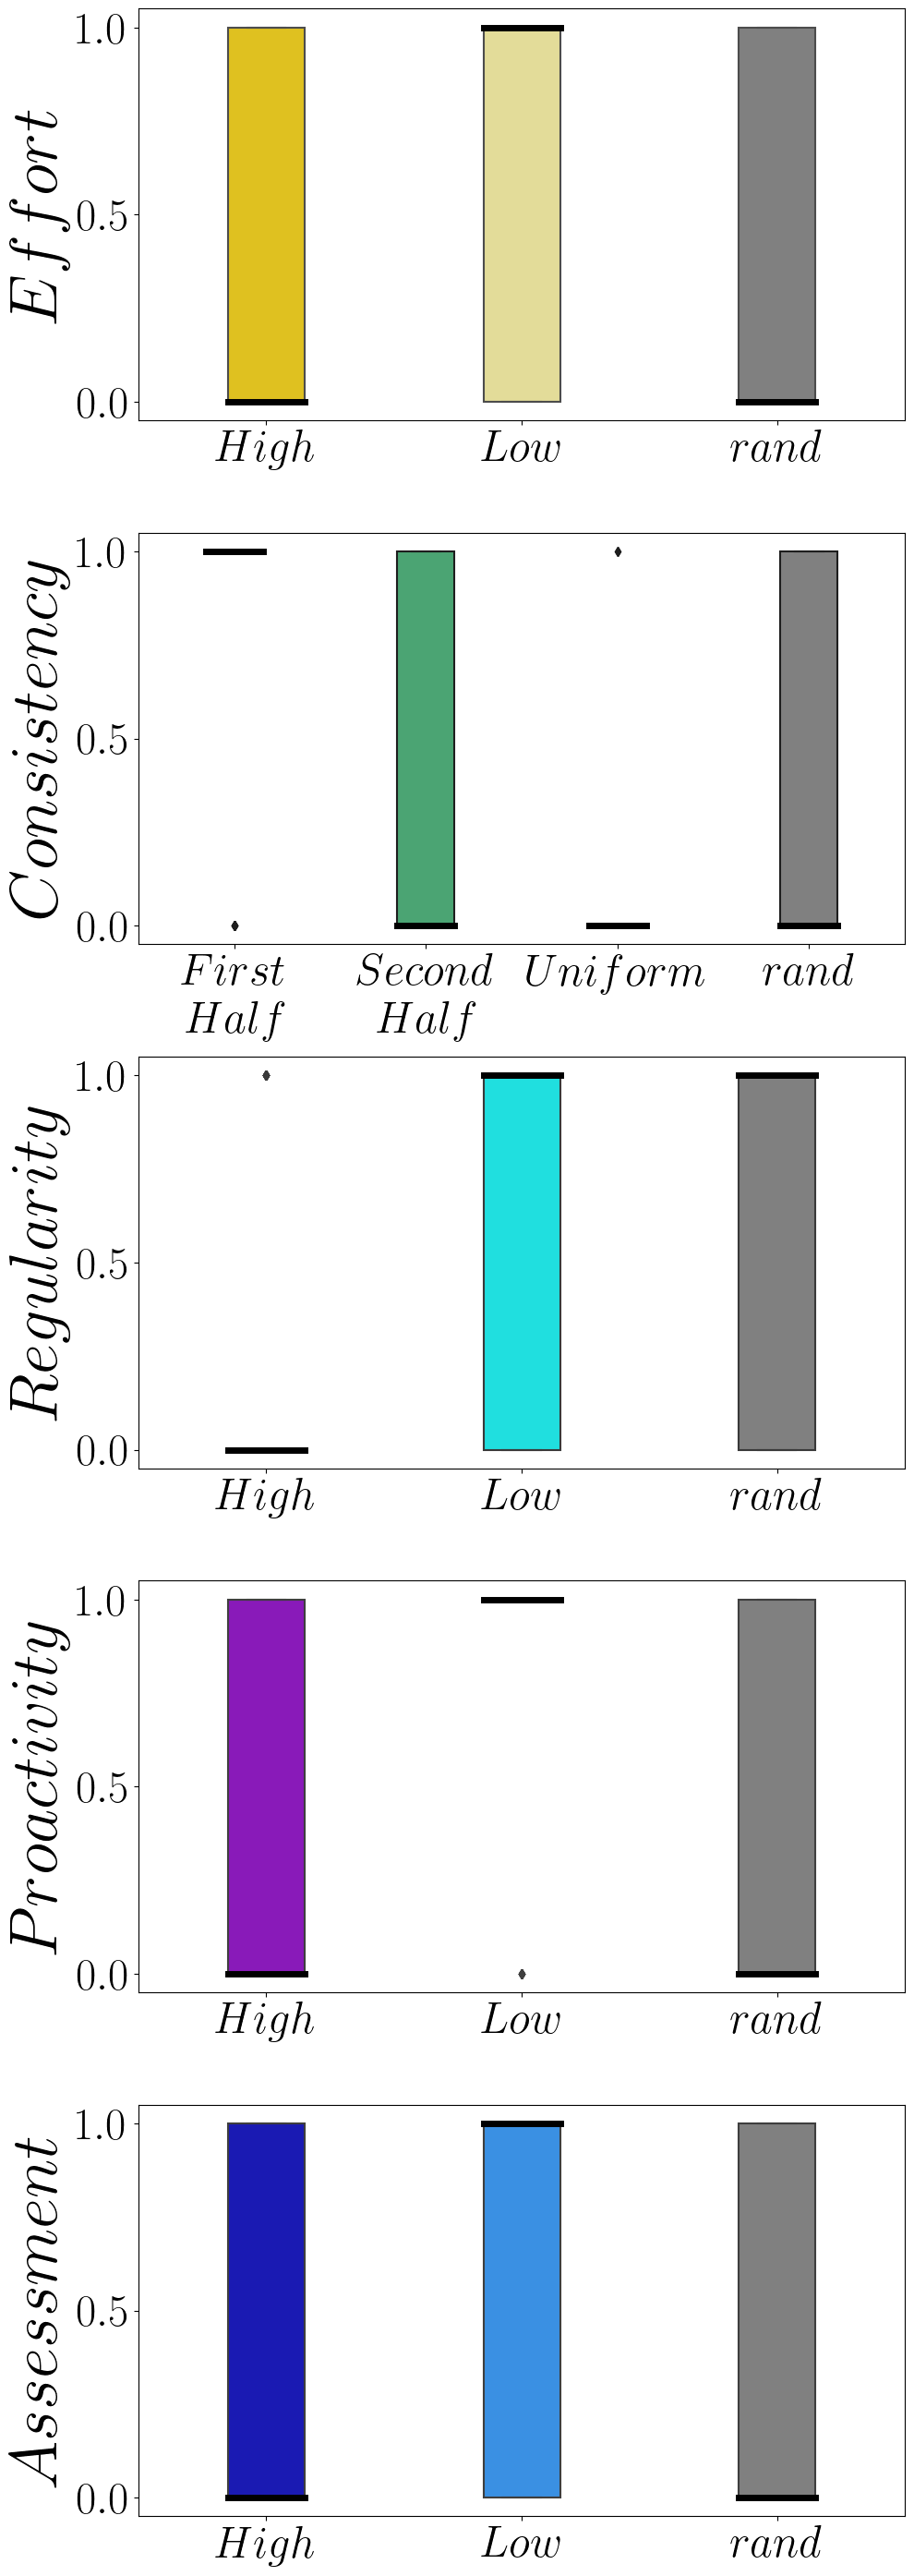

In [259]:
layer = 'mlp_static'
metric='sign_count'
n_plots = 11

n = num_rands

#fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
fig, ax = plt.subplots(int(num_result_concepts), 1, figsize = (10, 28))

fs = 35

effort_pal = ['gold', 'khaki', 'gray']
consistency_pal = ['darkgreen', 'mediumseagreen', 'palegreen', 'gray']
regularity_pal = ['c', 'cyan', 'gray']
proactivity_pal = ['darkviolet', 'violet', 'gray']
control_pal = ['r', 'tomato', 'gray']
assessment_pal = ['mediumblue', 'dodgerblue', 'gray']

pals_dict = {'Effort': effort_pal,
            'Consistency': consistency_pal,
            'Regularity': regularity_pal,
            'Proactivity': proactivity_pal,
            'Control': control_pal,
            'Assessment': assessment_pal}

my_palette = ['skyblue', 'violet', 'cyan', 'gray']
for i in range(int(num_result_concepts)):
    esl = experimental_sets[(i) * n : ((i)+1) * n]
    Ps = []
    for z in range(len(esl[0])):
            Ps.append([item.cpu() for item in assemble_scores(scores, esl, z, layer, metric)])
    #ax[i].boxplot(Ps, showfliers=True)
    pal = my_palette[-len(Ps):]
    sns.boxplot(data=Ps, ax=ax[i], showfliers=True, width=0.3, medianprops={"color": "black", "linewidth": 5}, 
                palette=pals_dict[esl[0][0].name.split(' ')[-1]]
               )
    ax[i].set_xticklabels(tex_func(format_label_text(esl)))
    ax[i].set_ylabel('$' + esl[0][0].name.split(' ')[-1] + '$', fontsize = fs*1.5)
    ax[i].tick_params(axis='both', which='major', labelsize = fs)
    

#ax[2].set_xticklabels(tex_func(["a \\ b", '2', '3']))
plt.tight_layout()
plt.show()

#for i in range(1):
#    for j in range(5):

#        esl = experimental_sets[(i*5 + j) * n : ((i*5 + j)+1) * n]
        #P1, P2, pval, relation = get_pval(scores, esl, layer, metric)
#        Ps = []
#        for z in range(len(esl[0])):
#            Ps.append([item.cpu() for item in assemble_scores(scores, esl, z, layer, metric)])

        #ax[i, j].set_ylim([0, 1])
        
        #ax[i, j].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        #ax[i, j].set_title(format_label_text(esl)[0] + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
#        ax[i, j].boxplot(Ps, showfliers=True)

#        ax[i, j].set_xticklabels(format_label_text(esl), fontsize=fs)

#plt.show()


In [46]:
esl[0][0].name.split(' ')[1]

'Assessment'

In [57]:
ax[2].set_xticklabels()

TypeError: _set_ticklabels() missing 1 required positional argument: 'labels'

0, 0,

In [ ]:
plot_tcav_scores(experimental_sets, scores)

0, 1

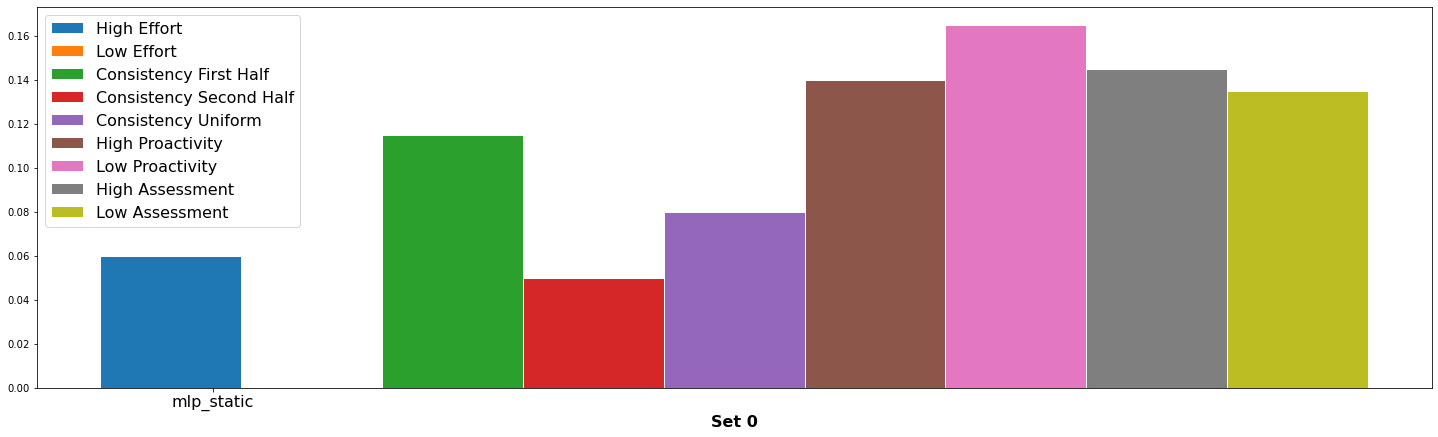

In [116]:
plot_tcav_scores(experimental_sets, scores)

1, 0

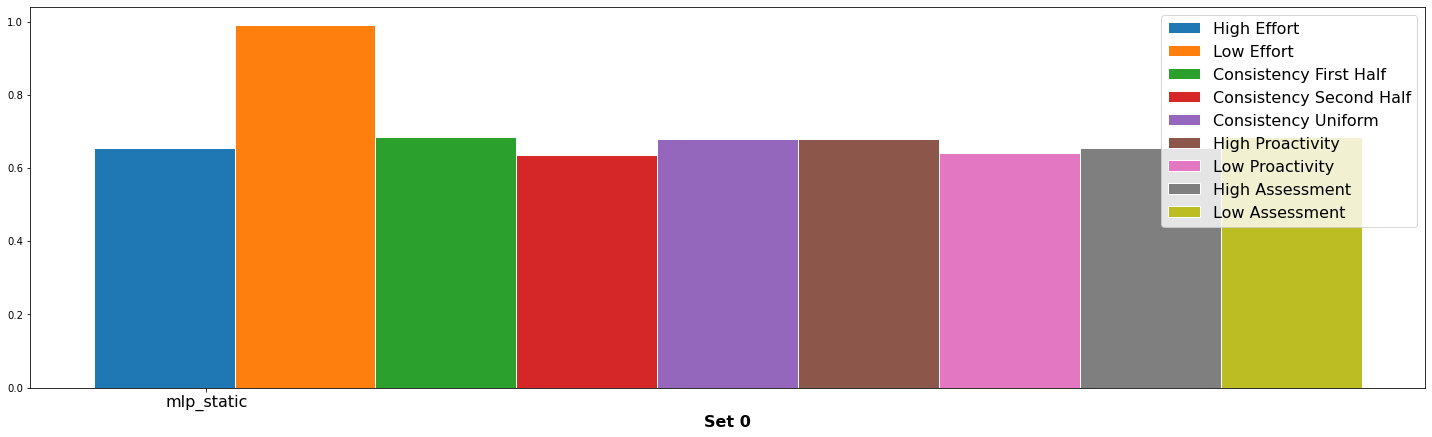

In [38]:
plot_tcav_scores(experimental_sets, scores)

In [ ]:
1, 1

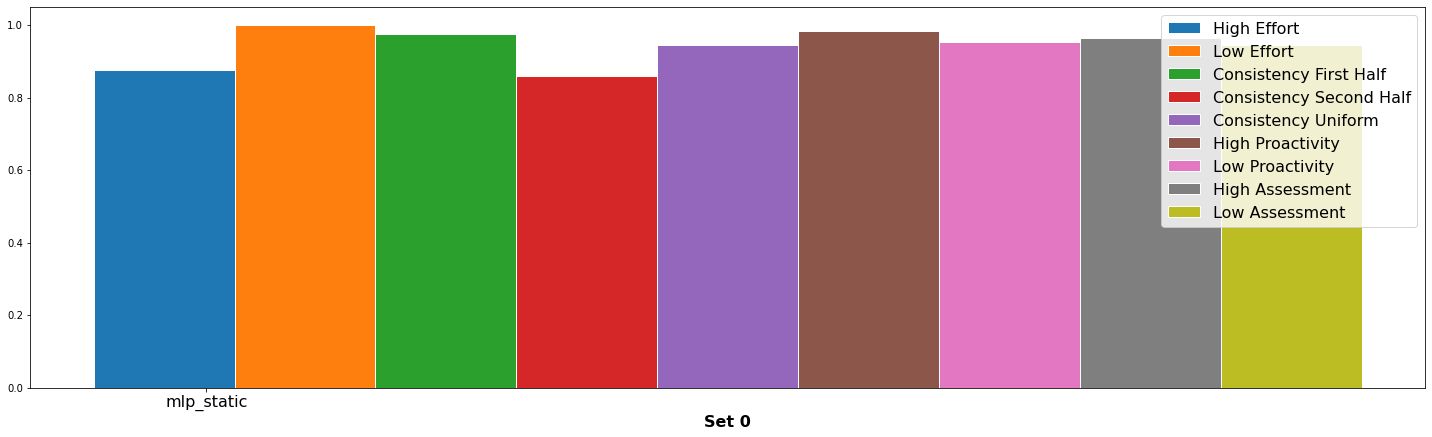

In [38]:
plot_tcav_scores(experimental_sets, scores)